In [1]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch, ImageDataset
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Compose,
    Resize,
    ToTensor,
    ScaleIntensityRange,
)
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.utils import set_determinism
from sklearn.model_selection import train_test_split

from monai.transforms import Resize

import nibabel as nib

import torch

# print_config()

In [2]:
set_determinism(seed=0)

In [3]:
# Make 3D segmentation model
device_name = "cuda:0"
device = torch.device(device_name)

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256),
    strides=(2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

# model = SegResNet(
#     spatial_dims=3,
#     init_filters=8,
#     input_channels=1,
#     output_channels=1,
#     norm_type="instance",
#     dropout_prob=0.2,
# ).to(device)

In [4]:
directory = ""

In [5]:


# Create a training data loader
# Add a dimension to the image
train_transforms = Compose(
    [
        lambda x: x.astype(np.float32),
        lambda x: x[np.newaxis, :, :, :],
        ToTensor(),
        Resize((512, 512, 128)),
        ScaleIntensityRange(a_min=-1024, a_max=3071, b_min=0.0, b_max=1.0, clip=True),
    ]
)
train_transforms_seg = Compose(
    [
        lambda x: x.astype(np.float32),
        lambda x: x[np.newaxis, :, :, :],
        ToTensor(),
        Resize((512, 512, 128)),
    ]
)

ct_scans_directory = directory + "data/train/volume"
segs_directory = directory + "data/train/seg"
ct_scans = os.listdir(ct_scans_directory)
segs = os.listdir(segs_directory)
ct_scans.sort()
segs.sort()

# Train test split
train_indexes, val_indexes = train_test_split(
    list(range(len(ct_scans))), test_size=0.1, random_state=0
)

# Create a training data loader
train_dataset = ImageDataset(
    image_files=[ct_scans_directory + "/" + ct_scans[i] for i in train_indexes],
    seg_files=[segs_directory + "/" + segs[i] for i in train_indexes],
    transform=train_transforms,
    seg_transform=train_transforms_seg
)
train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    pin_memory=torch.cuda.is_available(),
    pin_memory_device=device_name
)

# Create a validation data loader
# val_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"]),
#         EnsureChannelFirstd(keys=["image", "label"]),
#         Spacingd(
#             keys=["image", "label"],
#             pixdim=(1.5, 1.5, 2.0),
#             mode=("bilinear", "nearest"),
#         ),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         EnsureTyped(keys=["image", "label"]),
#         NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
#     ]
# )

# Create a validation data loader
val_dataset = ImageDataset(
    image_files=[ct_scans_directory + "/" + ct_scans[i] for i in val_indexes],
    seg_files=[segs_directory + "/" + segs[i] for i in val_indexes],
    transform=train_transforms,
    seg_transform=train_transforms_seg
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    num_workers=1,
    pin_memory=torch.cuda.is_available(),
    pin_memory_device=device_name
)

In [6]:
# Set loss function, optimizer and learning rate scheduler
loss_function = DiceLoss(sigmoid=True)
#loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
scaler = torch.cuda.amp.GradScaler()

In [7]:
# Training
max_epochs = 20
val_interval = 2
best_metric = np.inf
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in tqdm(range(max_epochs)):
    epoch_loss = 0
    for batch_data in train_loader:
        model.train()
        inputs, segs = (
            batch_data[0].to(device),
            batch_data[1].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, segs)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(f"{epoch + 1}/{max_epochs}, batch_train_loss: {loss.item():.4f}")
    print(f"epoch {epoch + 1} average loss: {epoch_loss / len(train_loader):.4f}")
    epoch_loss_values.append(epoch_loss / len(train_loader))
    lr_scheduler.step()

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            value_total = 0
            for val_data in val_loader:
                val_inputs, val_segs = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                val_outputs = model(val_inputs)
                value = loss_function(val_outputs, val_segs)
                value_total += value.item()
                print(f"{epoch + 1}/{max_epochs}, validation_dice: {value.item():.4f}")
            metric_values.append(value_total / len(val_loader))
            if value_total < best_metric:
                best_metric = value_total
                best_metric_epoch = epoch + 1
                torch.save(
                    model.state_dict(),
                    os.path.join(directory, "model/best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"{epoch + 1}/{max_epochs}, mean validation_dice: {value_total/len(val_loader):.4f}"
                )

print(
    f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}"
)

        

  0%|          | 0/20 [00:00<?, ?it/s]

1/20, batch_train_loss: 0.9930
1/20, batch_train_loss: 0.9966
1/20, batch_train_loss: 0.9959
1/20, batch_train_loss: 0.9991
1/20, batch_train_loss: 0.9967
1/20, batch_train_loss: 0.9971
1/20, batch_train_loss: 0.9774
1/20, batch_train_loss: 0.9964
1/20, batch_train_loss: 0.9940
1/20, batch_train_loss: 0.9949
1/20, batch_train_loss: 0.9987
1/20, batch_train_loss: 0.9984


In [ ]:
# Save last model
torch.save(
    model.state_dict(),
    os.path.join(directory, "model/model_last_epoch.pth"),
)

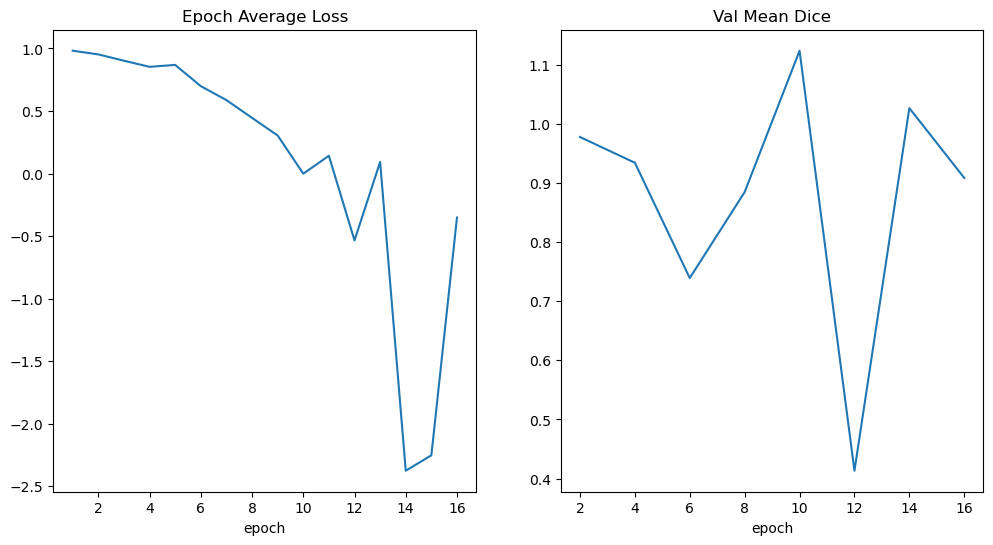

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the loss and metric
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()
plt.savefig(directory + "model/loss.png")

# Test a model

In [ ]:
# model_loaded = UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=1,
#     channels=(32, 64, 128, 256),
#     strides=(2, 2, 2),
#     num_res_units=2,
#     norm=Norm.BATCH,
# ).to(device)

# model_loaded.load_state_dict(
#     torch.load(os.path.join(directory, "model/best_metric_model.pth"))
# )